In [1]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#Determine if there is a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
PATH_train="./train"
PATH_val="./val"
PATH_test="./test"

In [4]:
TRAIN =Path(PATH_train)
VALID = Path(PATH_val)
TEST=Path(PATH_test)
print(TRAIN)
print(VALID)
print(TEST)

train
val
test


In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# learning rate
LR = 0.001

In [6]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [7]:
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data = datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)

In [8]:
print(train_data.class_to_idx)
print(valid_data.class_to_idx)

{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}


In [9]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

In [10]:
images,labels=next(iter(train_loader))
images.shape,labels.shape

(torch.Size([32, 3, 50, 50]), torch.Size([32]))

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['sick','unsick']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

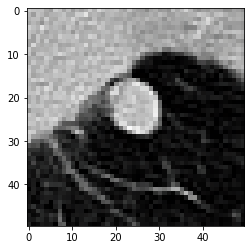

In [12]:
imshow(images[0])

In [13]:
#imshow(images[2])

/home/leo6532/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


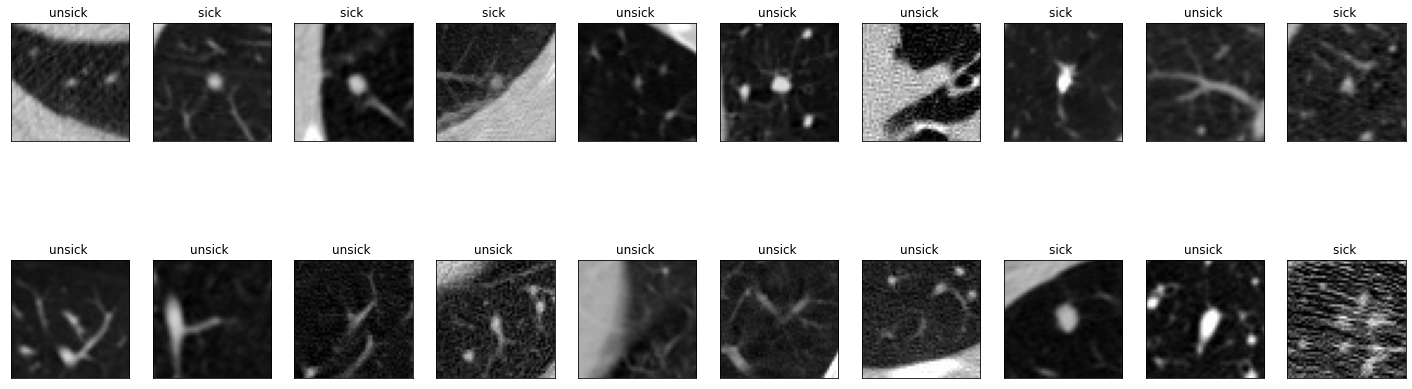

In [14]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
#display 20 images
for idx in np.arange(20):
     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
     imshow(images[idx])
     ax.set_title("{} ".format( classes[labels[idx]]))

In [15]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,220,220) 48
        #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2) 16 24 24
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0) #output_shape=(32,106,106) 20 20
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=1) #output_shape=(32,53,53) 10 10
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, stride=1, padding=0) #output_shape=(16,51,51) 10 10
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=1) #output_shape=(16,25,25) 5 5
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, stride=1, padding=0) #output_shape=(8,23,23) 5 5
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11) 8 5 5
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        #self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 2) 
        #self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        #out = self.output(out)

        return out

In [16]:
model = CNN_Model()
from torchsummary import summary
summary(model.cuda(), (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 22, 22]           4,640
              ReLU-5           [-1, 32, 22, 22]               0
         MaxPool2d-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 16, 22, 22]             528
              ReLU-8           [-1, 16, 22, 22]               0
         MaxPool2d-9           [-1, 16, 22, 22]               0
           Conv2d-10            [-1, 8, 22, 22]             136
             ReLU-11            [-1, 8, 22, 22]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Linear-13                  [-1, 512]         496,128
           Linear-14                   

In [17]:
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

In [18]:
import torch.optim as optim    
optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
criterion = nn.CrossEntropyLoss() 

running epoch: 1



	Training Loss: 0.052079 	Validation Loss: 0.738733
Validation loss decreased (inf --> 0.738733).  Saving model ...
running epoch: 2



	Training Loss: 0.055756 	Validation Loss: 0.651205
Validation loss decreased (0.738733 --> 0.651205).  Saving model ...
running epoch: 3



	Training Loss: 0.043246 	Validation Loss: 0.807062
running epoch: 4



	Training Loss: 0.069063 	Validation Loss: 0.768111
running epoch: 5



	Training Loss: 0.035480 	Validation Loss: 0.887806
[0.052078903192542575, 0.05575646255226385, 0.043246364677391326, 0.06906329388082952, 0.03548026853676434]
[0.7387325489662341, 0.6512051468733742, 0.807061517063985, 0.7681108849638687, 0.8878063221757193]


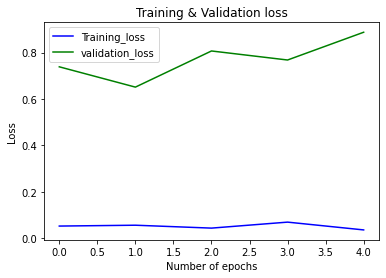

In [22]:
if train_on_gpu:
    model.cuda()
# number of epochs to train the model
n_epochs = 5 #170


valid_loss_min = np.Inf # track change in validation loss

#train_losses,valid_losses=[],[]

train_loss_i = [] 
valid_loss_i = []
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        with torch.no_grad():
            output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    #作圖接收矩陣
    train_loss_i.append(train_loss)
    valid_loss_i.append(valid_loss)

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_CNN.pth')
        valid_loss_min = valid_loss
#作圖區
print(train_loss_i) 
print(valid_loss_i)

plt.plot(range(n_epochs), train_loss_i,'b-', label='Training_loss')
plt.plot(range(n_epochs), valid_loss_i,'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#TEST MODEL

In [23]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [24]:
use_cuda = torch.cuda.is_available()
model.cuda()
test(test_loader, model, criterion, use_cuda)

Test Loss: 0.969328
Test Accuracy: 86% (1408/1622)
